In [1]:
!pip install lightgbm==3.3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 9.6 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.0.0
    Uninstalling lightgbm-4.0.0:
      Successfully uninstalled lightgbm-4.0.0


In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [3]:
ss = pd.read_csv('/content/drive/MyDrive/Fault Impact Analysis/SampleSubmission.csv')
train_path = "/content/drive/MyDrive/Fault Impact Analysis/train"
test_path = "/content/drive/MyDrive/Fault Impact Analysis/test"

In [4]:
ss.shape

(1932, 2)

In [5]:
import os
def get_train(path, train=True):
  data = []
  files = os.listdir(path)
  print(len(files))
  for file in files:
    if file.endswith(".csv.csv"):
      tmp = pd.read_csv(os.path.join(path, file))

      # Check csv where fault occurred throughout and drop them
      if all(tmp['fault_duration'] > 0):
          print(f"Skipping file as fault occurred in all: {file}")
          continue

      #i'm renaming each NE ID as the file name
      tmp['NE ID'] = file.split(".")[0]
      data.append(tmp)

  data = pd.concat(data, axis=0)
  data.reset_index(drop=True, inplace=True)
  return data

In [6]:
import os
def get_test(path):
  data = []
  files = os.listdir(path)
  print(len(files))
  for file in files:
    if file.endswith(".csv.csv"):
      tmp = pd.read_csv(os.path.join(path, file))

      tmp['NE ID'] = file.split(".")[0]
      data.append(tmp)

  data = pd.concat(data, axis=0)
  data.reset_index(drop=True, inplace=True)
  return data

In [7]:
# Load and filter the datasets
%%time
train = get_train(train_path)

7256
Skipping file as fault occurred in all: B0652-23_1.csv.csv
Skipping file as fault occurred in all: B0652-25_1.csv.csv
Skipping file as fault occurred in all: B0654-22_1.csv.csv
Skipping file as fault occurred in all: B0654-32_1.csv.csv
Skipping file as fault occurred in all: B0654-12_1.csv.csv
Skipping file as fault occurred in all: B0695-33_1.csv.csv
Skipping file as fault occurred in all: B0625-13_1.csv.csv
Skipping file as fault occurred in all: B0625-12_1.csv.csv
Skipping file as fault occurred in all: B0625-15_1.csv.csv
Skipping file as fault occurred in all: B0554-22_1.csv.csv
Skipping file as fault occurred in all: B0573-22_1.csv.csv
Skipping file as fault occurred in all: B0573-23_1.csv.csv
Skipping file as fault occurred in all: B0573-32_1.csv.csv
Skipping file as fault occurred in all: B0573-33_1.csv.csv
Skipping file as fault occurred in all: B0356-22_1.csv.csv
Skipping file as fault occurred in all: B0356-32_1.csv.csv
Skipping file as fault occurred in all: B0356-25_1.

In [8]:
%%time
test = get_test(test_path)

1932
CPU times: user 5.73 s, sys: 313 ms, total: 6.05 s
Wall time: 55.8 s


In [9]:
def separate_date(df):
  df['endTime'] = pd.to_datetime(df['endTime'], format='%Y-%m-%d %H:%M:%S')
  df['month'] = df['endTime'].dt.month
  df['day'] = df['endTime'].dt.day
  df['hour'] = df['endTime'].dt.hour
  df['weekday'] = df['endTime'].dt.weekday
  df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)
  return df

In [10]:
train = separate_date(train)
test = separate_date(test)

In [11]:
train.shape, test.shape

((905507, 16), (175150, 17))

In [14]:
def compute_features_shift_aggregate(data, feature_list, shift_vals=[1, 2]):

    all_difference_dfs = []
    # Compute differences for each shift and store in a list
    for shift_val in shift_vals:
        shifted_df = data.sort_values(by='endTime')[feature_list].shift(shift_val).sort_index()
        difference_df = data[feature_list] - shifted_df
        if shift_val < 0:
            suffix = f'_next_diff_{abs(shift_val)}'
        else:
            suffix = f'_prev_diff_{shift_val}'
        difference_df.columns = [col + suffix for col in difference_df.columns]

        all_difference_dfs.append(difference_df)

    # Combine all difference dataframes into one
    combined_difference_df = pd.concat(all_difference_dfs, axis=1)

    # Aggregate combined differences
    aggregated_df = combined_difference_df.groupby([data['hour']]).agg(['sum', 'mean', 'std', 'max', 'min'])
    aggregated_df.columns = ['_'.join(col).strip() for col in aggregated_df.columns.values]
    aggregated_df.reset_index(inplace=True)

    # Retrieve the last row for each hour
    last_rows_diff = combined_difference_df.groupby([data['hour']]).last().reset_index()
    first_rows_diff = combined_difference_df.groupby([data['hour']]).first().reset_index()

    # Merge aggregated results with last row differences
    result_df = pd.merge(first_rows_diff, last_rows_diff, on=["hour"], how="left")
    result_df = pd.merge(result_df, aggregated_df, on=[ "hour"], how="left")

    return result_df

In [15]:
def compute_aggregation(df, columns, operation):
    # Filter rows where 'fault_duration' > 0
    filtered_df = df[df['fault_duration'] > 0]

    if operation == "mean":
        agg_df = filtered_df[columns].mean().to_frame().T
    elif operation == "max":
        agg_df = filtered_df[columns].max().to_frame().T
    elif operation == "min":
        agg_df = filtered_df[columns].min().to_frame().T
    elif operation == "std":
        agg_df = filtered_df[columns].std().to_frame().T
    elif operation == "skew":
        agg_df = filtered_df[columns].skew().to_frame().T
    else:
        raise ValueError(f"Unsupported operation: {operation}")

    suffix = f"{operation}_fault"
    agg_df.columns = [f"{col}_{suffix}" for col in agg_df.columns]

    return agg_df

In [53]:
def extract_relevant_data(train, test, is_train=True):
    test = test.drop(columns=['Unnamed: 0'])
    group_df = pd.concat([train, test]).reset_index(drop=True)
    # Extracting the row just before the fault occurs
    before_fault = group_df[group_df['fault_duration'] == 0].drop(columns=['fault_duration','relation',"endTime",'hour','day','month'])
    before_fault1 = group_df[group_df['fault_duration'] == 0].drop(columns=['fault_duration','relation'])
    before_fault2 = group_df[group_df['fault_duration'] == 0].drop(columns=['fault_duration','relation',"endTime",'hour','day','month'])
    before_fault3 = group_df[group_df['fault_duration'] > 0]

    feature_list = ['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']
    a = compute_features_shift_aggregate(before_fault1, feature_list, shift_vals=[1])
    b = compute_features_shift_aggregate(before_fault1, feature_list, shift_vals=[-1])

    features = ['fault_duration']
    fault_rows = group_df[group_df['fault_duration'] > 0].groupby(['NE ID']).first().reset_index()
    fault_hour_mean = group_df[group_df['fault_duration'] > 0].groupby(['day', 'hour']).mean()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_mean_day_hour_fault").reset_index()
    fault_hour_max = group_df[group_df['fault_duration'] > 0].groupby(['day', 'hour']).max()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_max_day_hour_fault").reset_index()
    fault_hour_min = group_df[group_df['fault_duration'] > 0].groupby(['day', 'hour']).min()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_min_day_hour_fault").reset_index()
    fault_hour_std = group_df[group_df['fault_duration'] > 0].groupby(['day', 'hour']).std()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_std_day_hour_fault").reset_index()

    count_fault = group_df[group_df['fault_duration'] > 0].groupby(['NE ID']).count()[['fault_duration']].add_suffix(f"_count_ne_fault").reset_index()
    count_no_fault = group_df[group_df['fault_duration'] == 0].groupby(['NE ID']).count()[['fault_duration']].add_suffix(f"_count_ne_no_fault").reset_index()
    mean_fault = group_df[group_df['fault_duration'] > 0].groupby(['NE ID']).mean()[['fault_duration']].add_suffix(f"_mean_ne_fault").reset_index()
    std_fault = group_df[group_df['fault_duration'] > 0].groupby(['NE ID']).std()[['fault_duration']].add_suffix(f"_std_ne_fault").reset_index()
    skew_fault = group_df[group_df['fault_duration'] > 0].groupby(['NE ID']).skew()[['fault_duration']].add_suffix(f"_skew_ne_fault").reset_index()

    columns_to_compute = ['access_success_rate', 'resource_utilition_rate', 'TA', 'bler', 'cqi', 'mcs', 'data_rate']
    mean_fault_df = compute_aggregation(group_df, columns_to_compute, operation="mean")
    std_fault_df = compute_aggregation(group_df, columns_to_compute, operation="std")
    max_fault_df = compute_aggregation(group_df, columns_to_compute, operation="max")
    min_fault_df = compute_aggregation(group_df, columns_to_compute, operation="min")

    all_fault_df = pd.concat([mean_fault_df, std_fault_df, max_fault_df, min_fault_df], axis=1)

    # Get the last row for each "NE ID"
    rows = before_fault1.groupby(["NE ID"]).last()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate','hour']].add_suffix(f"_prev___1").reset_index()

    grouped1 = before_fault1.groupby("NE ID")

    # Get the last row for each group
    last_row = grouped1.last()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']]

    # Get the second to last row for each group
    second_last_row = grouped1.nth(-2)[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']]

    third_last_row = grouped1.nth(-3)[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']]

    fouth_last_row = grouped1.nth(-4)[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']]

    difference = last_row - second_last_row
    difference = difference.add_suffix(f"_diff_last_2").reset_index()

    difference1 = second_last_row - third_last_row
    difference1 = difference1.add_suffix(f"_diff_last_3").reset_index()

    mean_df = before_fault.groupby("NE ID", as_index=True).mean().add_prefix("mean_")
    std_df = before_fault.groupby("NE ID", as_index=True).std().add_prefix("std_")
    min_df = before_fault.groupby("NE ID", as_index=True).min().add_prefix("min_")
    max_df = before_fault.groupby("NE ID", as_index=True).max().add_prefix("max_")

    mdh_0 = before_fault1.groupby(['hour']).agg(
             mdh_asr_mean_0 = ('access_success_rate', 'mean'),
             mdh_asr_std_0 = ('access_success_rate', 'std'),
             mdh_asr_min_0 = ('access_success_rate', 'min'),
             mdh_asr_max_0 = ('access_success_rate', 'max'),
             mdh_asr_skew_0 = ('access_success_rate', 'skew'),


             mdh_rur_mean_0 = ('resource_utilition_rate', 'mean'),
             mdh_rur_std_0 = ('resource_utilition_rate', 'std'),
             mdh_rur_min_0 = ('resource_utilition_rate', 'min'),
             mdh_rur_max_0 = ('resource_utilition_rate', 'max'),
             mdh_rur_skew_0 = ('resource_utilition_rate', 'skew'),

             mdh_ble_mean_0 = ('bler', 'mean'),
             mdh_ble_std_0 = ('bler', 'std'),
             mdh_ble_min_0 = ('bler', 'min'),
             mdh_ble_max_0 = ('bler', 'max'),
             mdh_ble_skew_0 = ('bler', 'skew'),

             mdh_mcs_mean_0 = ('mcs', 'mean'),
             mdh_mcs_std_0 = ('mcs', 'std'),
             mdh_mcs_min_0 = ('mcs', 'min'),
             mdh_mcs_max_0 = ('mcs', 'max'),
             mdh_mcs_skew_0 = ('mcs', 'skew'),

             mdh_TA_mean_0 = ('TA', 'mean'),
             mdh_TA_std_0 = ('TA', 'std'),
             mdh_TA_min_0 = ('TA', 'min'),
             mdh_TA_max_0 = ('TA', 'max'),
             mdh_TA_skew_0 = ('TA', 'skew'),

             mdh_dr_mean_0 = ('data_rate', 'mean'),
             mdh_dr_std_0 = ('data_rate', 'std'),
             mdh_dr_min_0 = ('data_rate', 'min'),
             mdh_dr_max_0 = ('data_rate', 'max'),
             mdh_dr_skew_0 = ('data_rate', 'skew')
             ).reset_index()

    add_data = pd.concat([mean_df, std_df], axis=1)

    add_data = add_data.merge(fault_rows[['NE ID','fault_duration', 'relation', 'month', 'day', 'hour']], on=['NE ID'], how='left')

    add_data = add_data.merge(rows, on='NE ID', how='left')
    add_data = add_data.merge(difference, on='NE ID', how='left')
    add_data = add_data.merge(difference1, on='NE ID', how='left')

    add_data = add_data.merge(count_fault, on='NE ID', how='left')
    add_data = add_data.merge(count_no_fault, on='NE ID', how='left')
    add_data = add_data.merge(mean_fault, on='NE ID', how='left')
    add_data = add_data.merge(std_fault, on='NE ID', how='left')

    print(add_data.shape)

    if is_train:
        # Get the last 'data_rate' for each 'NE ID' from before_fault1
        last_data_rate = before_fault1.groupby('NE ID').last()['data_rate']

        # Create a dictionary for faster lookup
        fault_data_rate_dict = fault_rows.set_index('NE ID')['data_rate'].to_dict()

        # Create a labeling function based on the condition
        def label_data(ne_id):
          if ne_id in last_data_rate and ne_id in fault_data_rate_dict and last_data_rate[ne_id] > fault_data_rate_dict[ne_id]:
              return 1
          else:
              return 0

        # Apply the labeling function
        add_data['label'] = add_data['NE ID'].apply(label_data)

    # add_data = add_data.merge(fault_hour_mean, on=['day','hour'], how='left')
    add_data = add_data.merge(fault_hour_max, on=['day','hour'], how='left')
    add_data = add_data.merge(fault_hour_min, on=['day','hour'], how='left')
    add_data = add_data.merge(fault_hour_std, on=['day','hour'], how='left')

    # Replicate the row of mean_df for the length of df
    replicated_df = pd.DataFrame(np.repeat(all_fault_df.values, len(add_data), axis=0), columns=all_fault_df.columns)

    add_data = pd.concat([add_data, replicated_df], axis=1)
    print(add_data.shape)


    add_data = add_data.merge(mdh_0, left_on='hour_prev___1', right_on='hour', how='left')
    add_data = add_data.merge(a, left_on=['hour_prev___1'], right_on=['hour'], how='left')
    print(add_data.shape)

    # Splitting the data back to train and test based on unique "NE ID" from test
    test_ne_ids = test["NE ID"].unique()
    extracted_test = add_data[add_data["NE ID"].isin(test_ne_ids)]
    extracted_train = add_data[~add_data["NE ID"].isin(test_ne_ids)]

    return extracted_train, extracted_test

In [54]:
%%time
extracted_train, extracted_test = extract_relevant_data(train, test)

(9156, 50)
(9156, 100)
(9156, 181)
CPU times: user 13.2 s, sys: 762 ms, total: 14 s
Wall time: 14.3 s


In [55]:
extracted_train.shape, extracted_test.shape

((7224, 181), (1932, 181))

In [56]:
df = train.copy()

In [57]:
df["extracted_NE_ID"] = df["NE ID"].str.split("_").str[0]

In [58]:
test_copy = test.copy()

In [59]:
test_copy["extracted_NE_ID"] = test_copy["NE ID"].str.split("_").str[0]

In [63]:
def focu_on_fault(train, test):
    test = test.drop(columns=['Unnamed: 0'])
    group_df = pd.concat([train, test]).reset_index(drop=True)

    mean_rows = group_df[group_df['fault_duration'] == 0].groupby(['extracted_NE_ID']).mean()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_mean_all_fault").reset_index()
    std_rows = group_df[group_df['fault_duration'] == 0].groupby(['extracted_NE_ID']).std()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_std_all_fault").reset_index()
    max_rows = group_df[group_df['fault_duration'] == 0].groupby(['extracted_NE_ID']).max()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_max_all_fault").reset_index()
    min_rows = group_df[group_df['fault_duration'] == 0].groupby(['extracted_NE_ID']).min()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_min_all_fault").reset_index()
    skew_rows = group_df[group_df['fault_duration'] == 0].groupby(['extracted_NE_ID']).skew()[['access_success_rate','resource_utilition_rate','TA','bler','cqi','mcs','data_rate']].add_suffix(f"_skew_all_fault").reset_index()

    mean_fault = group_df[group_df['fault_duration'] > 0].groupby(['extracted_NE_ID']).mean()[['fault_duration']].add_suffix(f"_mean_ne_extract_fault").reset_index()
    std_fault = group_df[group_df['fault_duration'] > 0].groupby(['extracted_NE_ID']).std()[['fault_duration']].add_suffix(f"_std_ne_extract_fault").reset_index()

    fault_rows = mean_rows.merge(std_rows, on=['extracted_NE_ID'], how='left')
    fault_rows = fault_rows.merge(max_rows, on=['extracted_NE_ID'], how='left')
    fault_rows = fault_rows.merge(min_rows, on=['extracted_NE_ID'], how='left')

    test_ne_ids = test["extracted_NE_ID"].unique()
    extracted_test = fault_rows[fault_rows["extracted_NE_ID"].isin(test_ne_ids)]
    extracted_train = fault_rows[~fault_rows["extracted_NE_ID"].isin(test_ne_ids)]

    print(extracted_train.shape, extracted_test.shape)

    return extracted_train, extracted_test

In [64]:
%%time
tr, te = focu_on_fault(df, test_copy)

(2861, 29) (556, 29)
CPU times: user 5.69 s, sys: 183 ms, total: 5.87 s
Wall time: 5.87 s


In [65]:
extracted_train['extracted_NE_ID'] = extracted_train["NE ID"].str.split("_").str[0]
extracted_test['extracted_NE_ID'] = extracted_test["NE ID"].str.split("_").str[0]

In [66]:
column_names = extracted_train.columns.tolist()
column_names[column_names.index('hour_x')] = 'hour'
extracted_train.columns = column_names

In [67]:
column_names = extracted_test.columns.tolist()
column_names[column_names.index('hour_x')] = 'hour'
extracted_test.columns = column_names

In [68]:
extracted_train.shape, extracted_test.shape

((7224, 182), (1932, 182))

In [69]:
extracted_train = extracted_train.merge(tr, on='extracted_NE_ID', how='left')

In [70]:
extracted_test = extracted_test.merge(te, on='extracted_NE_ID', how='left')

In [71]:
extracted_train.shape, extracted_test.shape

((7224, 210), (1932, 210))

In [72]:
extracted_test.head()

,NE ID,mean_access_success_rate,mean_resource_utilition_rate,mean_TA,mean_bler,mean_cqi,mean_mcs,mean_data_rate,mean_weekday,mean_is_weekend,...,cqi_max_all_fault,mcs_max_all_fault,data_rate_max_all_fault,access_success_rate_min_all_fault,resource_utilition_rate_min_all_fault,TA_min_all_fault,bler_min_all_fault,cqi_min_all_fault,mcs_min_all_fault,data_rate_min_all_fault
0,B0017-25_24,99.666576,38.982000,3.261393,10.626261,5.896339,5.871992,4.922731,0.000000,0.000000,...,6.302236,8.301610,10.963935,88.532371,5.724,2.686268,6.555953,5.106033,4.121271,0.432873
1,B0017-25_25,99.453582,92.664000,2.804900,16.015768,5.552038,4.885502,0.744580,0.000000,0.000000,...,6.302236,8.301610,10.963935,88.532371,5.724,2.686268,6.555953,5.106033,4.121271,0.432873
2,B0017-25_26,99.546228,80.028000,3.151677,13.437244,5.226969,4.896700,1.561278,0.000000,0.000000,...,6.302236,8.301610,10.963935,88.532371,5.724,2.686268,6.555953,5.106033,4.121271,0.432873
3,B0017-25_27,NaN,10.956667,3.687649,9.319546,5.836830,6.715879,7.253831,1.000000,0.000000,...,6.302236,8.301610,10.963935,88.532371,5.724,2.686268,6.555953,5.106033,4.121271,0.432873
4,B0017-32_1,99.721841,55.918492,2.830446,11.975014,6.267658,6.942147,6.438656,3.348485,0.363636,...,6.883596,11.207832,28.727142,90.738835,6.110,2.512474,6.976157,5.583631,4.093645,0.703845


In [73]:
extracted_train['label'].value_counts()

0    3657
1    3567
Name: label, dtype: int64

In [74]:
X = extracted_train.drop(columns=['NE ID','label','extracted_NE_ID'])
y = extracted_train['label']
tes = extracted_test.drop(columns=['NE ID','label','extracted_NE_ID'])

In [75]:
def identify_correlated(df, threshold):
    corr_matrix = df.corr().abs()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    reduced_corr_matrix = corr_matrix.mask(mask)
    features_to_drop = [c for c in reduced_corr_matrix.columns if any(reduced_corr_matrix[c] > threshold)]
    return features_to_drop

In [76]:
%%time
features_to_drop1 = identify_correlated(X, .99)

CPU times: user 1.19 s, sys: 0 ns, total: 1.19 s
Wall time: 1.22 s


In [77]:
len(features_to_drop1)

19

In [78]:
lgb_params = {'num_leaves': 150,
 'max_depth': -1,
 'learning_rate': 0.01,
 'min_split_gain': 0.24664278438096177,
 'min_child_samples': 6,
 'min_child_weight': 0.009893701073314746,
 'subsample': 0.7922433830062748,
 'colsample_bytree': 0.7702871526306962,
 'reg_alpha': 5.989782196924695,
 'reg_lambda': 9.450977321771916,
 'random_state': 42,
 'n_estimators': 5000}

In [79]:
def remove_duplicate_columns(df):
    df = df.loc[:, ~df.columns.duplicated(keep='first')]
    return df

In [80]:
X = remove_duplicate_columns(X)
tes = remove_duplicate_columns(tes)

In [81]:
%%time
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
import numpy as np
from sklearn.metrics import f1_score


# Initialize the model as XGBRegressor with 500 trees
model = lgb.LGBMClassifier(**lgb_params)

# Define the number of folds for the KFold cross-validation
n_folds = 10

# Create an instance of KFold with 5 splits, shuffled, and with random_state set to 1235
kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=1235)

# Create arrays to store the out-of-fold and prediction values
oofs = np.zeros((len(X)))
oofs1 = np.zeros((len(X)))
preds = np.zeros((len(tes)))

# Iterate over the folds
for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
    # Split the data into training and testing sets for this fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the training data
    model.fit(X_train, y_train, eval_set = [(X_test, y_test)],verbose=0, early_stopping_rounds=100)

    # Predict on the validation set
    vp2 = model.predict_proba(X_test)[:,1]
    vp = model.predict_proba(X_test)
    vp1 = (vp[:, 1] >= 0.35).astype('int')

    # Calculate the validation score as the root mean squared error between the true values and predictions
    val_score = f1_score((y_test), (vp1))
    print(f'\nFold {fold+1} Val score: {val_score}\n')

    # Predict on the test set
    tp = model.predict_proba(tes)[:, 1]

    # Store the validation predictions in the oofs array
    oofs[test_index] = vp1
    oofs1[test_index] = vp2
    # Average the predictions over the 5 folds and store in the preds array
    preds += tp/n_folds

# Calculate the out-of-fold score as the root mean squared error between the true values and predictions
oof_score = f1_score((y), (oofs))
print(f'\nOOF F1 score is : {oof_score}')


Fold 1 Val score: 0.7210884353741497


Fold 2 Val score: 0.7357630979498861


Fold 3 Val score: 0.6977777777777777


Fold 4 Val score: 0.7254237288135594


Fold 5 Val score: 0.7149321266968327


Fold 6 Val score: 0.706145251396648


Fold 7 Val score: 0.7138193688792166


Fold 8 Val score: 0.7285067873303168


Fold 9 Val score: 0.7248322147651007


Fold 10 Val score: 0.709750566893424


OOF F1 score is : 0.7177355947433449
CPU times: user 6min 43s, sys: 2.53 s, total: 6min 46s
Wall time: 4min 4s


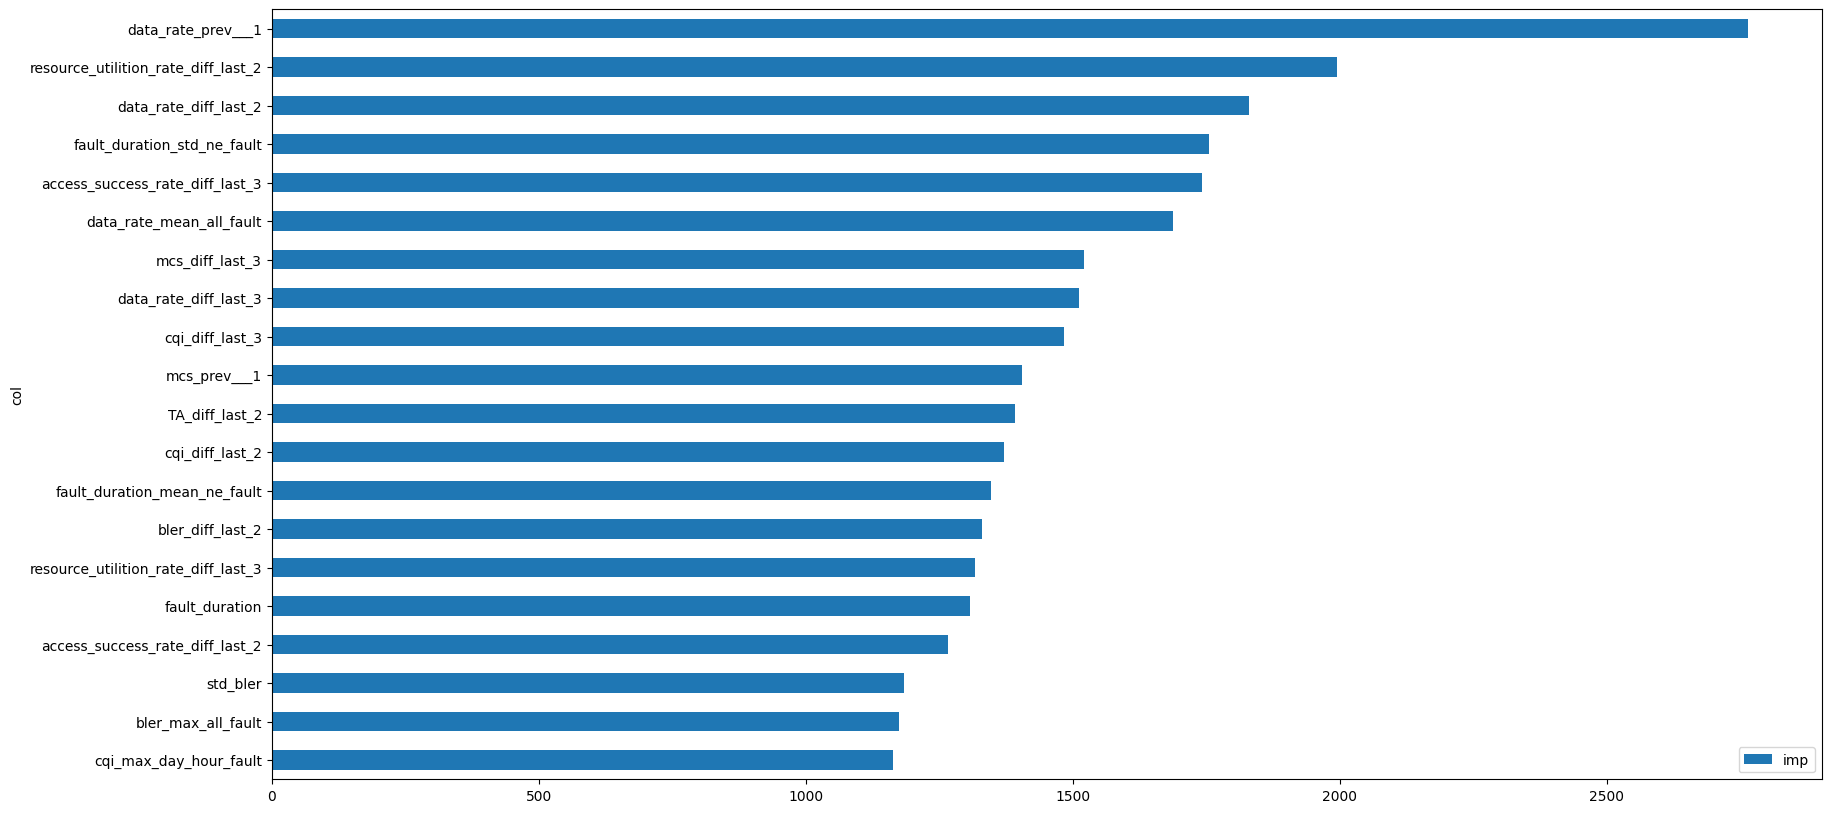

In [82]:
fea_imp = pd.DataFrame({'imp':model.feature_importances_, 'col': X.columns})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-20:]
_ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))

In [104]:
d = {'ID':extracted_test['NE ID'], 'data_rate_t+1_trend':preds}
submit = pd.DataFrame(d)

In [105]:
submit.head()

,ID,data_rate_t+1_trend
0,B0017-25_24,0.483329
1,B0017-25_25,0.183968
2,B0017-25_26,0.172498
3,B0017-25_27,0.714519
4,B0017-32_1,0.709722


In [106]:
submit['data_rate_t+1_trend'] = np.where(submit['data_rate_t+1_trend'] >= 0.37, 1, 0)

In [107]:
submit['data_rate_t+1_trend'].value_counts(1)

1    0.701863
0    0.298137
Name: data_rate_t+1_trend, dtype: float64

In [109]:
submit.to_csv('stake007.csv', index=False)